# PREDICTIVE ANALYSIS

> **Sử dụng dataset: ds_salaries.csv**

Dự đoán mức lương công việc trong ngành Khoa học Dữ liệu dựa trên một số thông tin cụ thể có trong bộ dữ liệu

**Import thư viện:**

In [1]:
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics


**Đọc dữ liệu từ file csv:**

In [2]:
data = pd.read_csv('ds_salaries.csv')

### Xử lý tỷ lệ lạm phát trong bộ dữ liệu

#### Điều chỉnh mức lương thu nhập phù hợp với thực trạng thị trường hiện nay ở Mỹ

**Giải thích:**

1. Định nghĩa tỷ lệ lạm phát ở thị trường Mỹ và thị trường toàn cầu hiện nay. Tỷ lệ lạm phát này sẽ dùng để điều chỉnh mức lương thu nhập dựa trên năm và tiền tệ của từng quốc gia.

2. Định nghĩa hàm điều chỉnh mức lương thu nhập dựa trên năm và tiền tệ của từng quốc gia. Hàm này sẽ trả về mức lương thu nhập sau khi điều chỉnh. Nếu như năm làm việc là năm 2023, thì lương thu nhập không thay đổi, trả về mức lương ban đầu.

3. Xác định số năm làm việc của nhân viên.

4. Tính toán mức lương thay đổi sau khi điều chỉnh theo tỷ lệ lạm phát

5. Áp dụng hàm điều chỉnh lương thu nhập theo tỷ lệ lạm phát vào bộ dữ liệu. Đồng thời, tạo thêm 1 cột mới có tên là 'adjusted_salary' để lưu trữ mức lương sau khi điều chỉnh.

In [3]:
us_inflation_rates = {2019: 0.0181, 2020: 0.0123, 2021: 0.0470, 2022: 0.065}
global_inflation_rates = {2019: 0.0219, 2020: 0.0192, 2021: 0.0350, 2022: 0.088}

# Hàm điều chỉnh lương thu nhập theo tỷ lệ lạm phát
def adjust_salary(row):
    year = row['work_year']
    original_salary = row['salary_in_usd']
    currency = row['salary_currency']

    if year == 2023:
        return original_salary

    adjusted_salary = original_salary
    for y in range(year, 2023):
        if currency == 'USD':
            inflation_rate = us_inflation_rates[y]
        else:
            inflation_rate = global_inflation_rates[y]

        adjusted_salary *= (1 + inflation_rate)

    return adjusted_salary

# Áp dụng hàm điều chỉnh lương vào bộ dữ liệu và tạo thêm 1 cột mới
data['adjusted_salary'] = data.apply(adjust_salary, axis=1)

In [4]:
data[['adjusted_salary']]

,adjusted_salary
0,85847.000000
1,30000.000000
2,25500.000000
3,175000.000000
4,120000.000000
...,...
3750,465053.312718
3751,168373.305000
3752,118520.868532
3753,112877.017650


**Một số thông tin quan trọng trong bộ dữ liệu:**

* experience_level (định tính): Mức độ kinh nghiệm của nhân viên trong công việc

* employment_type (định tính): Loại hình làm việc của nhân viên

* job_category (định tính): Loại công việc của nhân viên làm trong năm

* adjusted_salary (định lượng): Lương thu nhập sau khi được điều chỉnh theo tỷ lệ lạm phát

* employment_residence (định tính): Nơi cư trú của nhân viên

* remote_ratio (tỷ lệ): Tỷ lệ làm việc từ xa của nhân viên

* company_location (định tính): Vị trí của công ty

* company_size (định tính): Quy mô của công ty

**I. Chuẩn bị dữ liệu:**

In [5]:
import pycountry

# tạo dictionary để mapping country code với country name
country_map = {}
for country in pycountry.countries:
    country_map[country.alpha_2] = country.name

# thay thế các giá trị trong cột 'employee_residence' bằng dictionary
data['employee_residence'] = data['employee_residence'].replace(country_map)
data['company_location'] = data['company_location'].replace(country_map)

In [6]:
df = data.copy()
df = df.drop(['work_year','salary','salary_currency','salary_in_usd','salary_in_usd','job_title'], axis=1)

In [7]:
df.head()

,experience_level,employment_type,employee_residence,remote_ratio,company_location,company_size,adjusted_salary
0,SE,FT,Spain,100,Spain,L,85847.0
1,MI,CT,United States,100,United States,S,30000.0
2,MI,CT,United States,100,United States,S,25500.0
3,SE,FT,Canada,100,Canada,M,175000.0
4,SE,FT,Canada,100,Canada,M,120000.0


#### 1> Clustering Analysis: Phân tích nhóm dữ liệu

**II. Tiền xử lý dữ liệu:**

In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# Create a copy of the dataframe to not alter the original
df_preprocessed = df.copy()

# Preprocessing: Label encoding for categorical variables
le = LabelEncoder()
categorical_features = ['experience_level', 'employment_type', 'employee_residence', 'company_location', 'company_size', 'remote_ratio']
for feature in categorical_features:
    df_preprocessed[feature] = le.fit_transform(df[feature])

# Preprocessing: MinMax scaling for numerical/ratio variables
mm = MinMaxScaler()
numerical_features = ['adjusted_salary']
for feature in numerical_features:
    df_preprocessed[feature] = mm.fit_transform(df[feature].values.reshape(-1,1))

**III. T-SNE Clustering**

T-SNE là một thuật toán giúp giảm chiều dữ liệu, giúp dữ liệu có thể được trực quan hóa trên một không gian 2 chiều. T-SNE là viết tắt của t-distributed stochastic neighbor embedding.

In [12]:
from sklearn.manifold import TSNE
import plotly.express as px

# Apply t-SNE with different perplexity and learning rate
tsne = TSNE(n_components=2, random_state=42, perplexity=50, learning_rate=200)
tsne_results = tsne.fit_transform(df_preprocessed)

# Plotly Interactive plot
df_tsne = pd.DataFrame(data = tsne_results, columns = ['Dim_1', 'Dim_2'])
df_tsne['adjusted_salary'] = df['adjusted_salary']
fig = px.scatter(df_tsne, x='Dim_1', y='Dim_2', color='adjusted_salary', title='t-SNE plot colored by Salary')
fig.show()

**Giải thích kết quả:**

* Từ biểu đồ t-SNE: Trục x và trục y biểu thị hai chiều (Dim_1 và Dim_2) của biểu đồ t-SNE. Các kích thước này không có ý nghĩa cụ thể nhưng chúng được xây dựng theo cách cố gắng duy trì cấu trúc của dữ liệu nhiều chiều trong không gian 2D.

* Các điểm nằm rải rác trên cốt truyện và dường như không có sự phân tách rõ ràng giữa các cụm. Điều này có thể gợi ý rằng dữ liệu không có cấu trúc mạnh hoặc có thể cần phải điều chỉnh các tham số t-SNE.

* Thanh màu bên phải hiển thị mức lương từ 100k đến 500k. Có vẻ như có các điểm đủ màu sắc trên toàn bộ cốt truyện, điều này cho thấy rằng không có mối quan hệ rõ ràng giữa các kích thước t-SNE và mức lương.

### 2> Salary Prediction: Dự đoán mức lương

**II. Loại bỏ ngoại lệ bằng phương pháp IQR**

In [14]:
# Convert columns to numeric data type
df['adjusted_salary'] = pd.to_numeric(df['adjusted_salary'], errors='coerce')

# Calculate quartiles and IQR
Q1 = df['adjusted_salary'].quantile(0.25)
Q3 = df['adjusted_salary'].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
df = df[~((df['adjusted_salary'] < (Q1 - 1.5 * IQR)) | (df['adjusted_salary'] > (Q3 + 1.5 * IQR)))]

In [16]:
df

,experience_level,employment_type,employee_residence,remote_ratio,company_location,company_size,adjusted_salary
0,SE,FT,Spain,100,Spain,L,85847.000000
1,MI,CT,United States,100,United States,S,30000.000000
2,MI,CT,United States,100,United States,S,25500.000000
3,SE,FT,Canada,100,Canada,M,175000.000000
4,SE,FT,Canada,100,Canada,M,120000.000000
...,...,...,...,...,...,...,...
3749,SE,FT,United States,100,United States,L,183984.075000
3751,MI,FT,United States,100,United States,L,168373.305000
3752,EN,FT,United States,100,United States,S,118520.868532
3753,EN,CT,United States,100,United States,L,112877.017650


**III. Phân loại lương thành 7 khoảng khác nhau**

In [17]:
quantiles = [0, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 1]
bin_edges = [df['adjusted_salary'].quantile(q) for q in quantiles]

# Convert the continuous salary variable into 7 discrete bins based on quantiles
salary_labels = ['low', 'low-mid', 'mid', 'mid-high', 'high', 'very-high', 'Top']
df['salary_range'] = pd.cut(df['adjusted_salary'], bins=bin_edges, labels=salary_labels, include_lowest=True)

C:\Users\Lan Anh\AppData\Local\Temp\ipykernel_15204\3840777122.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**IV. Tiền xử lý dữ liệu**

In [19]:
encoder = LabelEncoder()
categorical_features = ['employment_type', 'experience_level', 
                        'employee_residence', 'remote_ratio', 'company_location', 'company_size']
for feature in categorical_features:
    df[feature] = encoder.fit_transform(df[feature])
# Split the dataset into training and testing sets
X = df.drop(["adjusted_salary", "salary_range"], axis=1)
y = df["salary_range"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\Lan Anh\AppData\Local\Temp\ipykernel_15204\1668866220.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lan Anh\AppData\Local\Temp\ipykernel_15204\1668866220.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lan Anh\AppData\Local\Temp\ipykernel_15204\1668866220.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

**V. Training and Validation: Tập huấn luyện và kiểm chứng**

In [20]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Định nghĩa mô hình
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Tạo ra các mô hình và in ra kết quả
best_model = None
best_score = -np.inf

print("Model performance:")
for name, model in models:
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{name} - Accuracy: {accuracy:.2f}")
    
    if accuracy > best_score:
        best_score = accuracy
        best_model = pipeline

print(f"Best model: {best_model.named_steps['model']} with accuracy: {best_score:.2f}")

Model performance:
Logistic Regression - Accuracy: 0.25
Random Forest - Accuracy: 0.29
Gradient Boosting - Accuracy: 0.28
Best model: RandomForestClassifier() with accuracy: 0.29


**VI. Confusion Matrix: Ma trận hỗn hợp**

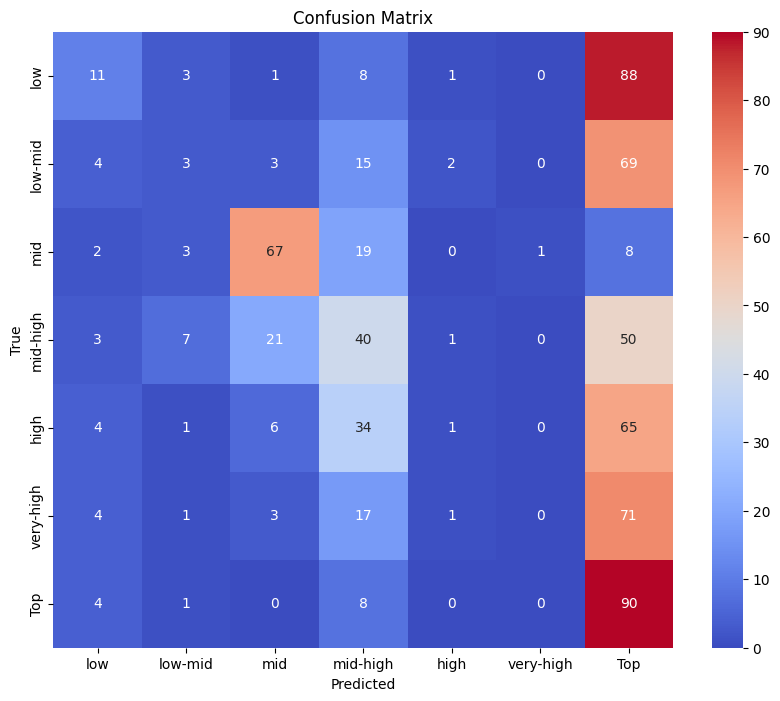

Classification Report:
              precision    recall  f1-score   support

         low       0.34      0.10      0.15       112
     low-mid       0.16      0.03      0.05        96
         mid       0.66      0.67      0.67       100
    mid-high       0.28      0.33      0.30       122
        high       0.17      0.01      0.02       111
   very-high       0.00      0.00      0.00        97
         Top       0.20      0.87      0.33       103

    accuracy                           0.29       741
   macro avg       0.26      0.29      0.22       741
weighted avg       0.26      0.29      0.22       741



In [21]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate the confusion matrix
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=salary_labels, yticklabels=salary_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=salary_labels))